In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs

In [2]:
N = 10000
d = 4
n_train = N * 0.8
n_val = N * 0.2

# Simulate a dataset

In [3]:
np.random.seed(9345)

In [4]:
x = np.random.normal(size=(N,1))

In [5]:
def noisy_polynomial(x):
    n = len(x)
    a = np.random.choice(range(1, 4))
    b = np.random.choice(range(1, 3))
    c = np.random.normal(size=(n,))
    return np.power(x, a) + np.power(x, b) + x + c

In [6]:
for _ in range(d - x.shape[1]):
    # All added columns are dependent on one other column
    dep_col = np.random.choice(range(0, d-x.shape[1]))
    x = np.column_stack((x, noisy_polynomial(x[:,dep_col])))

In [7]:
x_df = pd.DataFrame(x[1:1000], columns=[str(c) for c in range(x.shape[1])])

<Axes: xlabel='0', ylabel='1'>

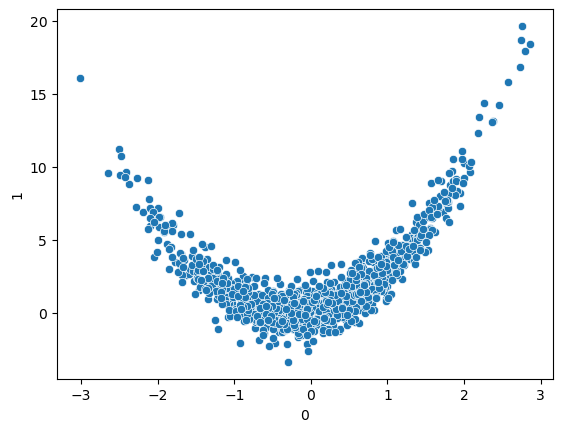

In [8]:
sns.scatterplot(data=x_df, x="0", y="1")

# Build autoencoder modules

In [9]:
class AE(torch.nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # self.encoder = Encoder(n_hidden_layers, input_dim, hidden_dim, latent_dim)
        # self.decoder = Decoder(n_hidden_layers, input_dim, hidden_dim, latent_dim)
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, latent_dim),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
net = AE(x.shape[1], x.shape[1] * 4, 1).to(device)
# print(net)

In [12]:
n_epochs = 1000
batch_size = 128
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum = 0.9)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [13]:
for epoch in range(n_epochs):
    
    # Train
    net.train()
    total_loss = 0.0
    avg_loss = 0.0
    
    for i, start in enumerate(range(0, x.shape[0], batch_size)):
        inputs = x[start:start + batch_size, :]
        inputs = torch.from_numpy(inputs).to(torch.float32).to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        running_loss = loss.item()
        # Divide total loss by number of mini batches
        avg_loss = total_loss / (i + 1)
    if epoch % 25 == 0:
        print(f"[{epoch + 1}] avg. train loss: {np.round(avg_loss, 3)}")
    # scheduler.step()


[1] avg. train loss: 8.523
[26] avg. train loss: 0.506
[51] avg. train loss: 0.496
[76] avg. train loss: 0.491
[101] avg. train loss: 0.488
[126] avg. train loss: 0.485
[151] avg. train loss: 0.48
[176] avg. train loss: 0.477
[201] avg. train loss: 0.475
[226] avg. train loss: 0.473
[251] avg. train loss: 0.472
[276] avg. train loss: 0.47
[301] avg. train loss: 0.469
[326] avg. train loss: 0.468
[351] avg. train loss: 0.468
[376] avg. train loss: 0.467
[401] avg. train loss: 0.467
[426] avg. train loss: 0.464
[451] avg. train loss: 0.461
[476] avg. train loss: 0.46
[501] avg. train loss: 0.459
[526] avg. train loss: 0.456
[551] avg. train loss: 0.455
[576] avg. train loss: 0.454
[601] avg. train loss: 0.452
[626] avg. train loss: 0.45
[651] avg. train loss: 0.446
[676] avg. train loss: 0.446
[701] avg. train loss: 0.442
[726] avg. train loss: 0.44
[751] avg. train loss: 0.44
[776] avg. train loss: 0.438
[801] avg. train loss: 0.44
[826] avg. train loss: 0.438
[851] avg. train loss: 0.4

In [16]:
with torch.no_grad():
    inputs = torch.from_numpy(x[95:98]).to(device).to(torch.float32)
    outputs = net(inputs)
    print(inputs)
    print(outputs)

tensor([[ 0.6923,  2.2793,  1.5640,  1.6301],
        [ 0.9655,  1.5332,  3.9578,  2.3127],
        [-0.8420,  0.3230, -2.7645,  1.5403]], device='cuda:0')
tensor([[ 0.6772,  1.7636,  2.3814,  1.6271],
        [ 0.8044,  2.3164,  2.6359,  2.2180],
        [-0.9545,  0.7804, -3.1659,  1.0169]], device='cuda:0')
